# D'autres types d'agents...

In [1]:
from atom import *
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

## ZIT avec des probabilités d'ask et de bid différentes

Les ZIT de base envoient soit un ask soit un bid, les deux ayant une probabilité $\dfrac{1}{2}$. On veut créer des ZIT qui envoient un ask avec probabilité $p_{ask}$, un bid avec probabilité $p_{bid}$, et rien avec probabilité $1-p_{ask}-p_{bid}$.

In [2]:
class ZITTrader_v2(Trader):
    def __init__(self, available_assets=[], initial_assets=None, cash=0, p_ask=.5, p_bid=.5):
        Trader.__init__(self, available_assets, initial_assets, cash)
        self.p_ask = p_ask # Probabilité d'envoyer un ask
        self.p_bid = p_bid # Probabilité d'envoyer un bid
    def __str__(self):
        return "ZITv2(%.2f/%.2f) "%(self.p_ask, self.p_bid) + super().__str__()
    def place_order(self, market):
        r = random.random() # 0 <= r < 1
        if r <= self.p_ask+self.p_bid:
            return LimitOrder(random.choice(self.available_assets), self, 'ASK' if r <= self.p_ask else 'BID', random.randint(100, 999), random.randint(1, 9))
        else:
            return None

In [5]:
out = open('trace.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('Apple'))
t1 = ZITTrader_v2(['Apple'], p_ask=0.3, p_bid=0.6)
t2 = ZITTrader_v2(['Apple'], p_ask=0.6, p_bid=0.3)
m.add_trader(t1)
m.add_trader(t2)
for i in range(200):
    m.run_once()
m.print_state()
out.close()

print(t1.get_infos(m))
print(t2.get_infos(m))

ZITv2(0.30/0.60) 3:
Cash: -162148
Apple: 225
Wealth: -49873

ZITv2(0.60/0.30) 4:
Cash: 162148
Apple: -225
Wealth: 49873



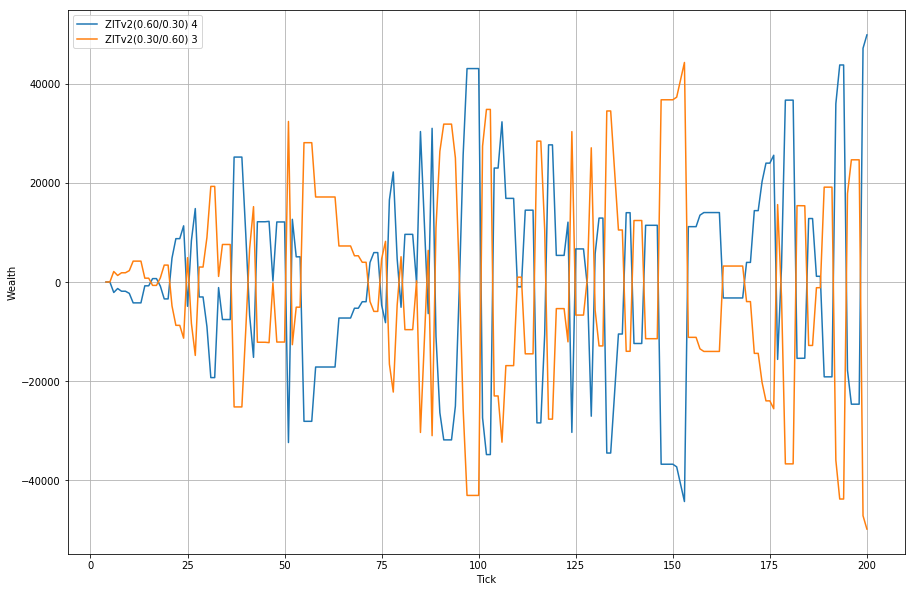

In [6]:
Wealth = process_wealth('trace.dat')
for agent in Wealth.keys():
    T, W = Wealth[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

## ZIT ne se ruinant pas

Nos ZIT (ceux de base comme ceux définis précedemment) peuvent à la fois avoir un cash négatif et une quantité d'actions négative. Nous allons faire des ZIT qui ne se ruinent pas en respectant le principe suivant : un agent ne place pas d'ordre tant qu'il lui reste un ordre dans un carnet d'ordre.

In [8]:
class ZITTrader_v3(Trader):
    def __init__(self, available_assets=[], initial_assets=None, cash=0):
        Trader.__init__(self, available_assets, initial_assets, cash)
    def __str__(self):
        return "ZITv3 " + super().__str__()
    def place_order(self, market):
        # On compte le nombre d'ordres placés dans les orderbooks par cet agent...
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset].asks.tree+market.orderbooks[asset].bids.tree if o.source == self]) for asset in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            asset = random.choice(self.available_assets)
            if direction == 'ASK' and self.assets[asset] > 0: # Si on a quantité > 0 d'actions pour cet asset...
                # On ne vend pas une quantité d'actions > à celle qu'on a.
                return LimitOrder(asset, self, 'ASK', random.randint(100, 999), random.randint(1, min(self.assets[asset], 9)))
            elif direction == 'BID' and self.cash >= 100: # Pour acheter, il faut de l'argent...
                price = random.randint(100, min(self.cash, 999))
                # On n'achète pas pour un volume > au cash qu'on a.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, min(self.cash//price, 9)))
        return None # Dans tous les autres cas, on ne place pas d'ordre.

Remarque : La façon de compter le nombre d'ordres placés par l'agent n'est clairement pas optimisée. À chaque fois qu'il faut placer un ordre, on fait $\Theta(\sum_{a\in Asset}|\text{Orderbook}_a|)$ opérations... Il suffirait d'ajouter un attribut booléen à la classe `ZITTrader_v3` qui garde en mémoire si un ordre est placé, et qui est modifée par la méthode `market.match` dès que cet ordre est retiré d'un carnet d'ordre. Ce n'est pas fait ici, car on va voir que ces ZIT ne vont pas avoir un comportement satisfaisant, et donc on ne pas s'en servir.

On va vérifier que ce ZIT fait bien ce qu'on veut sur des exemples simples. On va d'abord regarder ce qu'il se passe si on initialise les agents sans cash ni actions. Ils ne devraient placer aucun ordre.

In [9]:
m = Market()
m.add_asset(OrderBook('Apple'))
t = ZITTrader_v3(['Apple'])
m.add_trader(t)
m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelOrder;asset;agent
# Tick;nb_tick
# or Tick;nb_tick;asset;last_price
# Price;asset;bider;asker;price;qty
# Agent;name;cash;last_modified_asset;qty

Tick;1

# Nb orders received: 0
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 0


Des agents qui n'ont que du cash vont envoyer soit rien, soit des ordres bid.

In [10]:
m = Market()
m.add_asset(OrderBook('Apple'))
t = ZITTrader_v3(['Apple'], cash=10000)
m.add_trader(t)
for i in range(3):
    m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelOrder;asset;agent
# Tick;nb_tick
# or Tick;nb_tick;asset;last_price
# Price;asset;bider;asker;price;qty
# Agent;name;cash;last_modified_asset;qty

Tick;1
Tick;2
LimitOrder;Apple;ZITv3 6;BID;634;3
Tick;3

# Nb orders received: 1
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 1


Des agents qui n'ont que des actions vont envoyer soit rien, soit des ordres ask.

In [11]:
m = Market()
m.add_asset(OrderBook('Apple'))
t = ZITTrader_v3(['Apple'], initial_assets=[50])
m.add_trader(t)
for i in range(3):
    m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelOrder;asset;agent
# Tick;nb_tick
# or Tick;nb_tick;asset;last_price
# Price;asset;bider;asker;price;qty
# Agent;name;cash;last_modified_asset;qty

Tick;1
LimitOrder;Apple;ZITv3 7;ASK;338;4
Tick;2
Tick;3

# Nb orders received: 1
# Nb fixed prices: 0
# Leaving ask size: 1
# Leaving bid size: 0


Maintenant qu'on sait que notre ZIT fonctionne comme on le veut, on va désormais faire une simulation avec plusieurs agents et plusieurs tours de parole et afficher les prix.

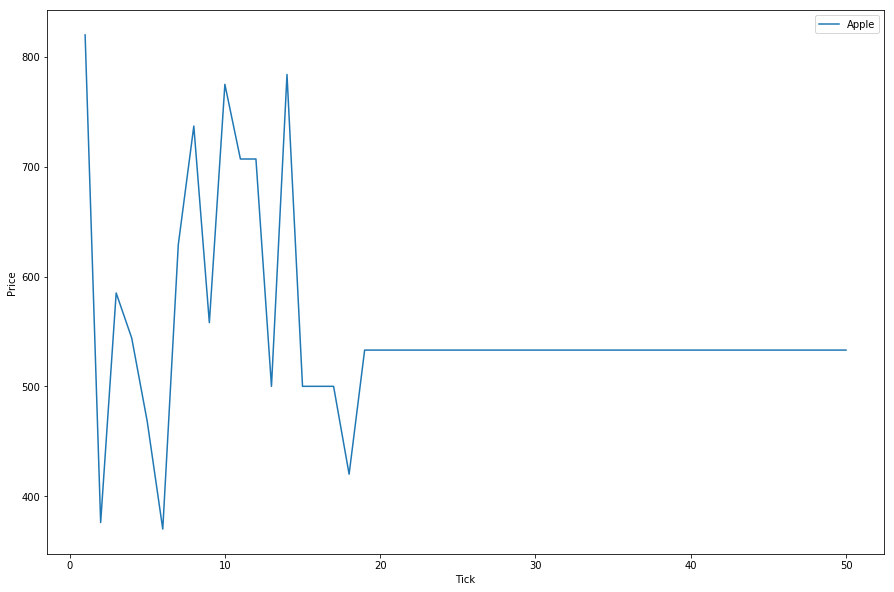

In [12]:
out = open('trace.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('Apple'))
for i in range(100):
    m.add_trader(ZITTrader_v3(['Apple'], initial_assets=[50], cash=10000))
for i in range(50):
    m.run_once()
m.print_state()
out.close()

Prices = process_prices_per_tick('trace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Tick')
plt.ylabel('Price')
plt.show()

Très rapidement, plus aucun prix n'est fixé, car chaque agent attend que son ordre soit exécuté.
On peut faire un `cat trace.dat | grep -E 'Price;|Tick;'` dans la console pour ne récupérer que les lignes commençant par "Tick;" ou par "Price;" pour voir quand ont été fixés les prix.

## Agent chartist

Un agent chartist possède deux paramètres $m < M$. En notant, $\widehat{p_t}(n)$ la moyenne des prix $p_{t-n}, \ldots, p_{t-1}$, l'agent choisi l'ordre à envoyer de la façon suivante :
* Si $\widehat{p_t}(m) > \widehat{p_t}(M)$, alors la tendance du prix est à la hausse et l'agent envoie un bid.
* Si $\widehat{p_t}(m) < \widehat{p_t}(M)$, alors la tendance du prix est à la baisse et l'agent envoie un ask.
* Si $\widehat{p_t}(m) = \widehat{p_t}(M)$, alors l'agent n'envoie pas d'ordre.

In [9]:
class Chartist(Trader):
    def __init__(self, available_assets=[], initial_assets=None, cash=0, m=3, M=5):
        Trader.__init__(self, available_assets, initial_assets, cash)
        self.m = m
        self.M = M
    def __str__(self):
        return "Chartist " + super().__str__()
    def place_order(self, market):
        def mean_price(asset, n):
            P = market.all_prices[asset]
            if len(P) >= n:
                s = sum([P[-i] for i in range(n)])
                return s/n
            return None
        asset = random.choice(self.available_assets)
        mean_m = mean_price(asset, self.m)
        mean_M = mean_price(asset, self.M)
        if mean_m != None and mean_M != None:
            if mean_m > mean_M:
                return LimitOrder(asset, self, 'BID', random.randint(1000, 9999), random.randint(1, 9))
            elif mean_m < mean_M:
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, 9))
        return None

In [14]:
out = open('trace.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('Apple'))
for i in range(2):
    m.add_trader(Chartist(['Apple']))
for i in range(2):
    m.add_trader(ZITTrader(['Apple']))
for i in range(100):
    m.run_once()
m.print_state()
out.close()

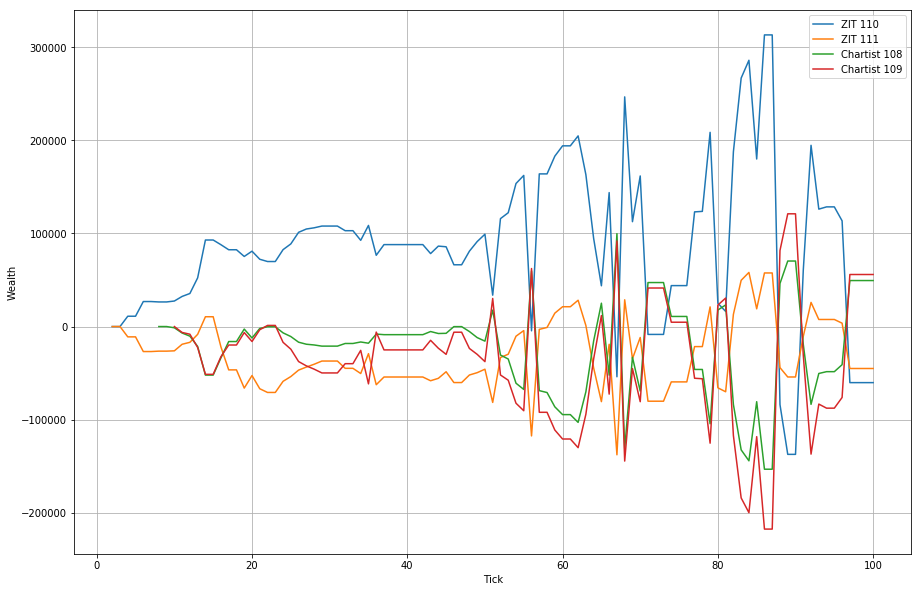

In [15]:
Wealth = process_wealth('trace.dat')
for agent in Wealth.keys():
    T, W = Wealth[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

On va regarder si un chartist a en moyenne un wealth plus élevé qu'un ZIT :

In [16]:
out = open('trace.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('Apple'))
for i in range(10):
    m.add_trader(Chartist(['Apple'], m=2, M=5))
for i in range(10):
    m.add_trader(ZITTrader(['Apple']))
for i in range(1000):
    m.run_once()
m.print_state()
out.close()

In [17]:
Wealth = process_wealth('trace.dat')
Mean_wealth_chartist = []
Mean_wealth_ZIT = []
for agent in Wealth.keys():
    _, W = Wealth[agent]
    if "Chartist" in agent:
        Mean_wealth_chartist.append(np.mean(np.array(W)))
    else:
        Mean_wealth_ZIT.append(np.mean(np.array(W)))
print("Wealth moyen des chartists : %i\nWealth moyen des ZIT : %i\n" % (np.mean(np.array(Mean_wealth_chartist)), np.mean(np.array(Mean_wealth_ZIT))))

Wealth moyen des chartists : -346048
Wealth moyen des ZIT : 344181



Nos chartists ont l'air de faire moins bien que des ZIT...

## Agent automate

On va créer un agent qui va prendre en paramètre un pile d'ordre et qui, à chaque fois qu'il aura la parole, renverra l'ordre au sommet de la pile.

In [18]:
class Automaton(Trader):
    def __init__(self, available_assets=[], initial_assets=None, cash=0, orders_list=[]):
        '''order_list est une liste de la forme (asset,direction,price,qty)'''
        Trader.__init__(self, available_assets, initial_assets, cash)
        self.orders_list = orders_list
    def __str__(self):
        return "Automaton "+ super().__str__()
    def place_order(self, market):
        if self.orders_list == []:
            return None
        else:
            a, d, p, q = self.orders_list.pop()
            return LimitOrder(a, self, d, p, q)

In [19]:
out = open('trace.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('Apple'))
# On ajoute un agent automate qui envoie en alternance un ordre de vente à 6000 et une ordre d'achat à 4000 (toujours avec une quantité de 9) 
m.add_trader(Automaton(['Apple'], orders_list=[('Apple', 'ASK', 6000, 9), ('Apple', 'BID', 4000, 9)]*50))
# On ajoute un autre agent automate qui envoie en alternance un ordre de vente à 4000 et une ordre d'achat à 6000 (toujours avec une quantité de 9) 
m.add_trader(Automaton(['Apple'], orders_list=[('Apple', 'ASK', 4000, 9), ('Apple', 'BID', 6000, 9)]*50))
for i in range(2):
    m.add_trader(ZITTrader(['Apple']))
for i in range(100):
    m.run_once()
m.print_state()
out.close()

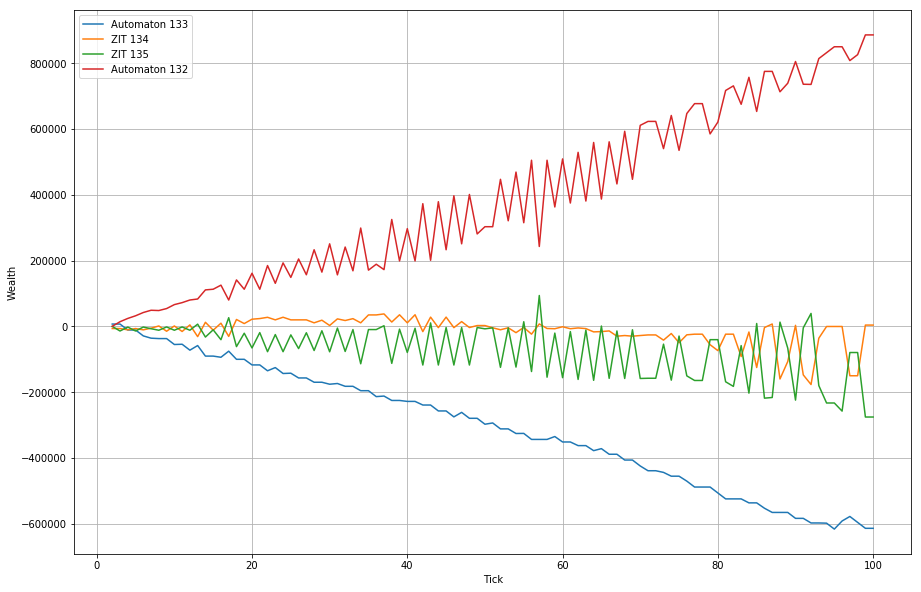

In [20]:
Wealth = process_wealth('trace.dat')
for agent in Wealth.keys():
    T, W = Wealth[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

On observe qu'un des deux automates a un wealth qui croît (c'est celui qui vend à 6000 et achète à 4000) et que l'autre décroît (celui qui vend à 4000 et achète à 6000).

## Agent arbitragist

In [3]:
class Arbitragist(Trader):
    def __init__(self, available_assets=[], initial_assets=None, cash=0, period=0, init_price=0):
        Trader.__init__(self, available_assets, initial_assets, cash)
        self.period = max(period, 2*len(available_assets))
        self.init_price = init_price
        self.time = period-1
        self.cancel_orders = []
        self.limit_orders = []
    def __str__(self):
        return "Arbitragist " + super().__str__()
    def make_available(self, asset, qty=0):
        available_assets.append(asset)
        self.assets[asset] = qty
        self.period = max(period, 2*len(available_assets))
    def place_order(self, market):
        self.time += 1
        removed_cancel_order = False
        if self.time == self.period:
            self.time = 0
            self.cancel_orders = [CancelOrder(asset, self) for asset in self.available_assets if market.orderbooks[asset].has_order_from(self)]
        if self.cancel_orders != []:
            o = self.cancel_orders.pop(0)
            removed_cancel_order = True
            return o
        if self.limit_orders != []:
            o = self.limit_orders.pop(0)
            return o
        if (self.time == 0 or removed_cancel_order) and self.cancel_orders == []:
            # Si on vient de vider la liste cancel_orders ou si on vient d'entamer une nouvelle période
            # sans avoir envoyé de CancelOrder, alors...
            w = self.get_wealth(market, self.init_price)
            # Vérifier ici que w >= 0 ?
            for asset in self.available_assets:
                p = market.prices[asset] if market.prices[asset] != None else self.init_price
                q = w//(len(self.available_assets)*p) - self.assets[asset]
                if q > 0:
                    self.limit_orders.append(LimitOrder(asset, self, 'ASK', p, q))
                elif q < 0:
                    self.limit_orders.append(LimitOrder(asset, self, 'BID', p, -q))
        return None

In [12]:
out = open('trace.dat', 'w')
m = Market(out, print_orderbooks=True)
m.add_asset(OrderBook('Apple'))
m.add_asset(OrderBook('Google'))
m.add_asset(OrderBook('Microsoft'))
m.add_trader(ZITTrader(['Apple', 'Google', 'Microsoft'], [5, 5, 5], cash=100000))
m.add_trader(Chartist(['Apple', 'Google', 'Microsoft'], [5, 5, 5], cash=100000))
m.add_trader(Arbitragist(['Apple', 'Google', 'Microsoft'], [5, 5, 5], cash=100000, period=10, init_price=5500))
for i in range(100):
    m.run_once()
m.print_state()
out.close()

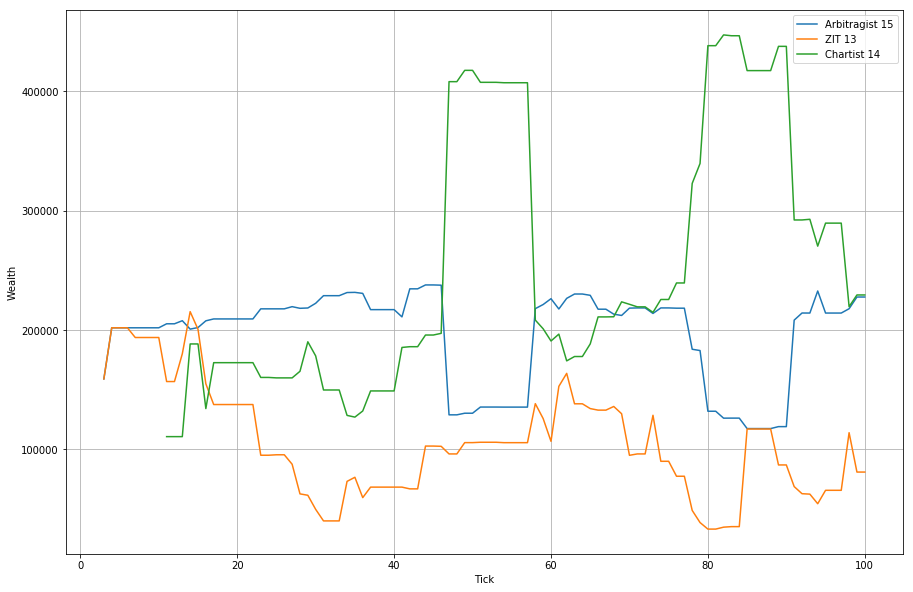

In [13]:
Wealth = process_wealth('trace.dat')
for agent in Wealth.keys():
    T, W = Wealth[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

On va comparer les wealths moyens des chartists, arbitragists et des ZITs :

In [42]:
out = open('trace.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('Apple'))
m.add_asset(OrderBook('Google'))
m.add_asset(OrderBook('Microsoft'))
for i in range(20):
    m.add_trader(ZITTrader(['Apple', 'Google', 'Microsoft'], [5, 5, 5], cash=100000))
    m.add_trader(Chartist(['Apple', 'Google', 'Microsoft'], [5, 5, 5], cash=100000, m=2, M=5))
    m.add_trader(Arbitragist(['Apple', 'Google', 'Microsoft'], [5, 5, 5], cash=100000, period=10, init_price=5500))
for i in range(1000):
    m.run_once()
m.print_state()
out.close()

In [43]:
Wealth = process_wealth('trace.dat')
Mean_wealth_arbitragist = []
Mean_wealth_chartist = []
Mean_wealth_ZIT = []
for agent in Wealth.keys():
    _, W = Wealth[agent]
    if "Chartist" in agent:
        Mean_wealth_chartist.append(np.mean(np.array(W)))
    elif "Arbitragist" in agent:
        Mean_wealth_arbitragist.append(np.mean(np.array(W)))
    else:
        Mean_wealth_ZIT.append(np.mean(np.array(W)))
print("Wealth moyen des arbitragists : %i\nWealth moyen des chartists : %i\nWealth moyen des ZITs : %i\n" % (np.mean(np.array(Mean_wealth_arbitragist)), np.mean(np.array(Mean_wealth_chartist)), np.mean(np.array(Mean_wealth_ZIT))))

Wealth moyen des arbitragists : -1553832
Wealth moyen des chartists : 361129
Wealth moyen des ZITs : 410572



Et si on se limite à arbitragists vs ZITs:

In [38]:
out = open('trace.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('Apple'))
m.add_asset(OrderBook('Google'))
m.add_asset(OrderBook('Microsoft'))
for i in range(20):
    m.add_trader(ZITTrader(['Apple', 'Google', 'Microsoft'], [5, 5, 5], cash=100000))
    m.add_trader(Arbitragist(['Apple', 'Google', 'Microsoft'], [5, 5, 5], cash=100000, period=10, init_price=5500))
for i in range(1000):
    m.run_once()
m.print_state()
out.close()

In [39]:
Wealth = process_wealth('trace.dat')
Mean_wealth_arbitragist = []
Mean_wealth_ZIT = []
for agent in Wealth.keys():
    _, W = Wealth[agent]
    if "Arbitragist" in agent:
        Mean_wealth_arbitragist.append(np.mean(np.array(W)))
    else:
        Mean_wealth_ZIT.append(np.mean(np.array(W)))
print("Wealth moyen des arbitragists : %i\nWealth moyen des ZITs : %i\n" % (np.mean(np.array(Mean_wealth_arbitragist)), np.mean(np.array(Mean_wealth_ZIT))))

Wealth moyen des arbitragists : -762831
Wealth moyen des ZITs : 558011

